In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
DataSet = xr.open_dataset("/content/drive/MyDrive/BTTAI_Project_Team_B/data_set_files/final_merged_dataset.nc")

In [4]:
#subset_da = DataSet.sel(lat=slice(24.396308, 49.384358), lon=slice(-124.848974, -66.885444),year=slice(2006,2050))
#subset_da.meanHuss.isel(year=19).plot()

In [5]:
subset_da = DataSet.sel(lat=slice(24.396308, 49.384358), lon=slice(-124.848974, -66.885444),year=slice(2006,2023))
df = subset_da.to_dataframe()
df.reset_index(inplace=True)
df.dropna(subset=['maxHuss'], inplace=True)
df = df.replace(to_replace='', value=np.nan)
#df = df.dropna(subset='null_variable')


df['wns'] = df['null_variable'].map(lambda x: 1 if x == 'W' else 0)


# Select instances where the label is 0
zero_label_indices = df[df['wns'] == 0].index

# Randomly select a subset of instances with label 0
# For example, let's select 30% of instances with label 0
subset_size = int(0.998 * len(zero_label_indices))
random_subset_indices = np.random.choice(zero_label_indices, size=subset_size, replace=False)

# Update the data by keeping only the randomly selected instances
df = df.drop(random_subset_indices)


# Update the data by keeping only the randomly selected instances
df.drop('null_variable', axis=1, inplace=True)
df

,lon,lat,year,maxHuss,maxPrec,maxTemp,meanHuss,meanPrec,meanRsds,meanTemp,minHuss,minPrec,minTemp,wns
3092,-124.375,42.375,2020,0.011600,103.272408,25.490143,0.006897,5.613972,158.763992,12.269543,0.002567,0.0,0.799561,0
7099,-123.875,48.125,2013,0.011976,80.737488,24.876984,0.006099,7.609082,134.594269,8.271371,0.002765,0.0,-10.129669,0
8248,-123.625,39.125,2010,0.009928,67.754852,25.238312,0.005296,4.720105,171.099350,13.351039,0.001848,0.0,4.779938,0
8321,-123.625,40.125,2011,0.011695,127.101822,30.300049,0.005527,5.964911,168.628357,11.975831,0.001774,0.0,-1.458649,0
8371,-123.625,40.875,2007,0.013128,70.214149,27.659546,0.005327,4.212955,168.701965,9.853312,0.001823,0.0,-6.472443,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406445,-68.375,44.625,2011,0.014342,65.899597,26.864532,0.005432,4.252778,156.201004,9.602814,0.000520,0.0,-17.554596,1
406793,-68.375,49.375,2017,0.011448,32.978134,26.113342,0.004056,3.478078,159.272491,3.652149,0.000157,0.0,-27.419754,0
408332,-68.125,45.875,2008,0.013898,45.040501,29.718567,0.004916,3.018500,154.400818,7.002240,0.000275,0.0,-19.869278,0
412100,-67.625,48.125,2014,0.014140,24.091349,27.974396,0.004383,3.229933,161.529053,3.523302,0.000268,0.0,-26.102509,0


In [6]:


# Sort DataFrame by Year in ascending order
df = df.sort_values(by='year')

# Function to check if WNS was detected in previous years for a specific coordinate
def wns_detected_past_years(row):
    past_years_data = df[(df['lat'] == row['lat']) & (df['lon'] == row['lon']) & (df['year'] < row['year'])]
    if len(past_years_data) > 0 and (past_years_data['wns'] == 1).any():
        return 1  # WNS detected in past years for this coordinate
    else:
        return 0  # WNS not detected in past years for this coordinate

# Apply the function to create a new column 'WNS_Detected_Past_Years'
df['WNS_Detected_Past_Years'] = df.apply(wns_detected_past_years, axis=1)

In [7]:


# Function to calculate distance between two coordinates using Haversine formula
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)

    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

# Function to calculate shortest distance for each point to a coordinate with previous WNS detection
def shortest_distance_to_wns(row):
    wns_detected_coords = df[(df['WNS_Detected_Past_Years'] == 1)]
    distances = [haversine(row['lat'], row['lon'], lat, lon) for lat, lon in wns_detected_coords[['lat', 'lon']].values]
    if len(distances) > 0:
        return min(distances)
    else:
        return None

# Apply the function to create a new column 'Shortest_Distance_to_WNS'
df['Shortest_Distance_to_WNS'] = df.apply(shortest_distance_to_wns, axis=1)

#after inspecting df it looks weird..

In [29]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, Product
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MinMaxScaler

# Assuming df is your DataFrame containing the data
# Assuming 'wns' is the target variable (1 for presence, 0 for absence)


# get label
label = 'wns'
y = df["wns"]
X = df.drop("wns", axis=1)

# split data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.10, random_state=1234)

# Split the data into training and testing sets based on the cutoff year
cutoff_year = 2020

X_train = X[df['year'] < cutoff_year]
y_train = y[df['year'] < cutoff_year]
X_test = X[df['year'] >= cutoff_year]
y_test = y[df['year'] >= cutoff_year]

# Normalize the features using Min-Max scaling (fit on training data and transform both training and testing data)


your_temporal_lengthscale = 2
your_smoothness_parameter = 1
your_spatial_lengthscale = 1
# Define temporal kernel
temporal_kernel = Matern(length_scale=your_temporal_lengthscale, nu=your_smoothness_parameter)

# Define spatial kernel
spatial_kernel = RBF(length_scale=your_spatial_lengthscale)

# Combine temporal and spatial kernels
combined_kernel = Product(temporal_kernel, spatial_kernel)

# Create a Gaussian Process Regressor with the combined kernel
gp_classifier = GaussianProcessRegressor(kernel=combined_kernel, n_restarts_optimizer=10)

# Fit the GP model to your training data
gp_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred, sigma = gp_classifier.predict(X_test, return_std=True)

# Assuming binary classification, threshold predictions (0.5)
binary_predictions = (y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, binary_predictions)
print(f'Accuracy: {accuracy:.4f}')
from sklearn.metrics import classification_report

# Define a threshold for binary classification
threshold = 0.5

# Convert predicted probabilities to binary labels
binary_predictions = (y_pred > threshold).astype(int)

# Generate the classification report
classification_report_result = classification_report(y_test, binary_predictions)
print("Classification Report:\n", classification_report_result)


# Define a threshold for binary classification
threshold = 0.9

# Convert predicted probabilities to binary labels
binary_predictions = (y_pred > threshold).astype(int)

# Generate the classification report
classification_report_result = classification_report(y_test, binary_predictions)
print("Classification Report:\n", classification_report_result)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Accuracy: 0.7917
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88       138
           1       0.39      0.30      0.34        30

    accuracy                           0.79       168
   macro avg       0.62      0.60      0.61       168
weighted avg       0.77      0.79      0.78       168

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.99      0.90       138
           1       0.33      0.03      0.06        30

    accuracy                           0.82       168
   macro avg       0.58      0.51      0.48       168
weighted avg       0.74      0.82      0.75       168



Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88       138
           1       0.39      0.30      0.34        30

    accuracy                           0.79       168
   macro avg       0.62      0.60      0.61       168
weighted avg       0.77      0.79      0.78       168



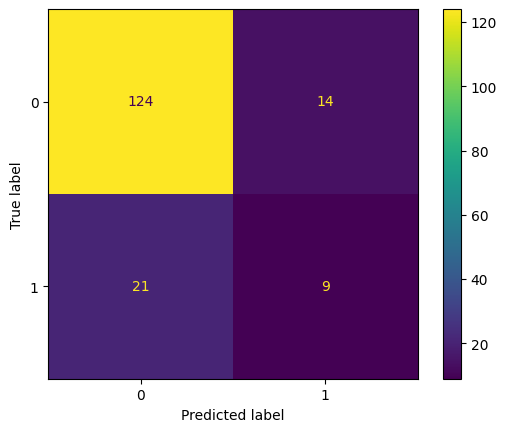

In [30]:
# Define a threshold for binary classification
threshold = 0.5

# Convert predicted probabilities to binary labels
binary_predictions = (y_pred > threshold).astype(int)

# Generate the classification report
classification_report_result = classification_report(y_test, binary_predictions)
print("Classification Report:\n", classification_report_result)



disp = ConfusionMatrixDisplay(confusion_matrix(y_test, binary_predictions))
disp.plot()

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80       138
           1       0.27      0.43      0.33        30

    accuracy                           0.69       168
   macro avg       0.56      0.59      0.57       168
weighted avg       0.75      0.69      0.72       168



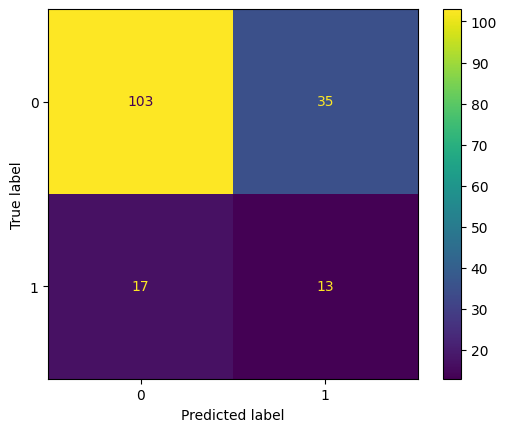

In [36]:
# Define a threshold for binary classification
threshold = 0.3

# Convert predicted probabilities to binary labels
binary_predictions = (y_pred > threshold).astype(int)

# Generate the classification report
classification_report_result = classification_report(y_test, binary_predictions)
print("Classification Report:\n", classification_report_result)



disp = ConfusionMatrixDisplay(confusion_matrix(y_test, binary_predictions))
disp.plot()

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90       138
           1       0.55      0.20      0.29        30

    accuracy                           0.83       168
   macro avg       0.70      0.58      0.60       168
weighted avg       0.79      0.83      0.79       168



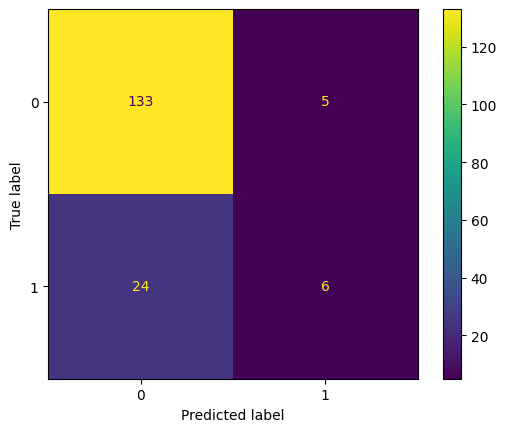

In [38]:
# Define a threshold for binary classification
threshold = 0.7

# Convert predicted probabilities to binary labels
binary_predictions = (y_pred > threshold).astype(int)

# Generate the classification report
classification_report_result = classification_report(y_test, binary_predictions)
print("Classification Report:\n", classification_report_result)



disp = ConfusionMatrixDisplay(confusion_matrix(y_test, binary_predictions))
disp.plot()

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90       138
           1       0.55      0.20      0.29        30

    accuracy                           0.83       168
   macro avg       0.70      0.58      0.60       168
weighted avg       0.79      0.83      0.79       168



NameError: ignored

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier

# Create a Gaussian Process Classifier with the combined kernel
gp_classifier = GaussianProcessClassifier(kernel=combined_kernel, n_restarts_optimizer=10)

# Fit the GP model to your training data
gp_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gp_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
classification_report_result = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_report_result)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Accuracy: 0.6429
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.78       138
           1       0.03      0.03      0.03        30

    accuracy                           0.64       168
   macro avg       0.41      0.40      0.41       168
weighted avg       0.65      0.64      0.65       168



In [ ]:
subset_da = DataSet.sel(lat=slice(24.396308, 49.384358), lon=slice(-124.848974, -66.885444),year=slice(2025))
df = subset_da.to_dataframe()
df.reset_index(inplace=True)
df.dropna(subset=['maxHuss'], inplace=True)
df = df.replace(to_replace='', value=np.nan)
#df = df.dropna(subset='null_variable')

# Update the data by keeping only the randomly selected instances
df.drop('null_variable', axis=1, inplace=True)
df

,lon,lat,year,maxHuss,maxPrec,maxTemp,meanHuss,meanPrec,meanRsds,meanTemp,minHuss,minPrec,minTemp
1880,-124.625,48.125,2006,0.009661,93.080559,23.765198,0.005861,7.369194,129.868134,10.309885,0.002125,0.0,-4.571747
1881,-124.625,48.125,2007,0.010276,71.963501,21.892517,0.006272,7.148562,134.327148,9.157192,0.002941,0.0,-1.255707
1882,-124.625,48.125,2008,0.010546,79.569580,18.406464,0.006400,10.171446,127.175758,9.170335,0.003059,0.0,0.045380
1883,-124.625,48.125,2009,0.010493,116.354836,23.448608,0.005665,10.867501,121.978271,9.798295,0.001608,0.0,-5.656860
1884,-124.625,48.125,2010,0.009748,77.657959,21.894501,0.005843,9.717582,127.913719,10.851817,0.003021,0.0,1.998596
...,...,...,...,...,...,...,...,...,...,...,...,...,...
461955,-67.125,48.875,2021,0.013859,49.752010,25.446899,0.004673,4.035824,156.414658,4.608527,0.000285,0.0,-21.159241
461956,-67.125,48.875,2022,0.014111,52.268139,29.762695,0.004435,3.753445,156.895508,5.123062,0.000284,0.0,-20.920166
461957,-67.125,48.875,2023,0.012564,43.042122,26.450562,0.004270,4.023201,153.472992,4.619852,0.000310,0.0,-25.559784
461958,-67.125,48.875,2024,0.013289,38.665165,26.940735,0.004529,3.378422,154.981094,5.138786,0.000300,0.0,-28.789490


In [ ]:
y_pred = gp_classifier.predict(df)

ValueError: ignored